In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
dl=.005
lam0 = np.arange(1,10+dl/2,dl)
lam1 = np.hstack([np.arange(-1.5,-1+dl/2,dl),np.arange(1,10+dl/2,dl)])
lam2 = np.hstack([np.arange(-10,-1+dl/2,dl),np.arange(1,10+dl/2,dl)])
lam3 = np.hstack([np.arange(-10,-1+dl/2,dl),np.arange(1,10+dl/2,dl)])

lams = [lam0,lam1,lam2,lam3]

params = [(1,.05),(1,.05),(1,.05),(1,0)]

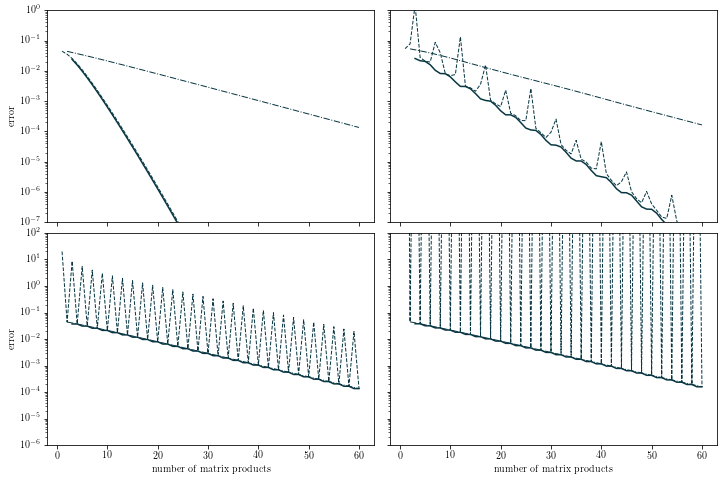

In [4]:
A,C = 0,1
fig,axs = plt.subplots(2,2,figsize=(12,8),sharey='row',sharex=True)
axs = axs.flatten()
fig.subplots_adjust(wspace=.05,hspace=.05)

for trial_idx in range(4):
    
    a,c = params[trial_idx]
    A_mat = lams[trial_idx].astype(np.float64)
    
    n = len(A_mat)
    b_vec = np.ones(n,dtype=np.double)
    b_vec /= np.linalg.norm(b_vec)

    M = lambda x: (A*x**2+C)
    N = lambda x: (a*x**2+c)
    f = lambda x: M(x)/N(x)
    
    fAb = f(A_mat)*b_vec
    
    K = 61
    Q,(a_,b_) = exact_lanczos(A_mat,b_vec,K,reorth=False)
    Q2,(a2_,b2_) = exact_lanczos(A_mat**2,b_vec,K,reorth=False)

    error_FA = np.full(K,np.nan)
    error_OR = np.full(K,np.nan)
    error_CG2 = np.full(K//2+1,np.nan)
    for i in range(1,K):
        
        # Lanczos-FA
        # solve via eigenvalue because breakdown in factorization
        T = np.diag(a_[:i]) + np.diag(b_[:i-1],1) + np.diag(b_[:i-1],-1)
        lank_FA = Q[:,:i]@np.linalg.solve(a*T@T+c*np.eye(i),(A*T@T+C*np.eye(i))[:,0])
        error_FA[i] = np.linalg.norm(N(A_mat)**.5*(fAb - lank_FA))

        
        # Lancos-OR-lm
        lan_lm= streaming_banded_rational(n,i,(A,0,C),(a,0,c))
        for j in range(i):
            lan_lm.read_stream(Q[:,j],a_[j],b_[j])
        lan_lm.finish_up()      
            
        error_OR[i] = np.linalg.norm(N(A_mat)**.5*(fAb - lan_lm()))

        
    for i in range(1,K//2+1):
        
        # msCG
        T2 = np.diag(a2_[:i]) + np.diag(b2_[:i-1],1) + np.diag(b2_[:i-1],-1)        
        CG2k = Q2[:,:i]@np.linalg.solve(a*T2+c*np.eye(i),(A*T2+C*np.eye(i))[:,0])
        error_CG2[i] = np.linalg.norm(N(A_mat)**.5*(fAb - CG2k))
    
    axs[trial_idx].plot(np.arange(K),error_FA/np.linalg.norm(N(A_mat)**.5*b_vec),linestyle='--',lw=1,color='#073642',label='lanczos-FA')
    axs[trial_idx].plot(np.arange(K),error_OR/np.linalg.norm(N(A_mat)**.5*b_vec),linestyle='-',color='#073642',label='lanczos-OR')
    axs[trial_idx].plot(np.arange(0,K+1,2),error_CG2/np.linalg.norm(N(A_mat)**.5*b_vec),linestyle='-.',lw=1,color='#073642',label='msCG')

    #d33682 
    #6c71c4
                        
    axs[trial_idx].set_yscale('log')
    
#    axs[trial_idx].plot(np.arange(0,15),1e-2*np.exp(-2*.5*np.arange(0,15)/(np.sqrt(100))),ls=':',color='#073642')
#    if trial_idx ==0:
#        axs[trial_idx].plot(np.arange(0,15),5e-3*np.exp(-2*np.arange(0,15)/(np.sqrt(max(A_mat)))),ls=':',color='#073642')
#    elif trial_idx == 1:
#        axs[trial_idx].plot(np.arange(0,15),5e-3*np.exp(-2*.5*np.arange(0,15)/(np.sqrt(np.abs(min(A_mat)*max(A_mat))))),ls=':',color='#073642')


axs[0].set_ylim(1e-7,1e0)
axs[2].set_ylim(1e-6,1e2)
for idx in [2,3]:
    axs[idx].set_xlabel('number of matrix products')

for idx in [0,2]:
    axs[idx].set_ylabel('error')


    
#axs[0].text(.8,.9,'$[1,10]$, $c=0.05$', ha='center', va='center', transform=axs[0].transAxes)
#axs[1].text(.8,.9,'$[-1.5,-1]\cup[1,10]$, $c=0.05$', ha='center', va='center', transform=axs[1].transAxes)
#axs[2].text(.8,.1,'$[-10,-1]\cup[1,10]$, $c=0.05$', ha='center', va='center', transform=axs[2].transAxes)
#axs[3].text(.8,.1,'$[-10,-1]\cup[1,10]$, $c=0$', ha='center', va='center', transform=axs[3].transAxes)

plt.savefig(f'imgs/lanczos_msCG_squared.pdf',bbox_inches='tight')